In [ ]:
! git clone https://github.com/jhonatansossa/deep-learning-project-JS.git

### Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
import statsmodels.tsa.api as smt

### Importando datos limpios

In [2]:
df_master = pd.read_parquet(r'/content/deep-learning-project-JS/data/02_intermediate/cleaned_train.parquet.snappy', engine='pyarrow')
df_transactions = pd.read_parquet(r'/content/deep-learning-project-JS/data/02_intermediate/cleaned_transactions.parquet.snappy', engine='pyarrow')
df_stores = pd.read_parquet(r'/content/deep-learning-project-JS/data/02_intermediate/cleaned_stores.parquet.snappy', engine='pyarrow')
df_oil = pd.read_parquet(r'/content/deep-learning-project-JS/data/02_intermediate/cleaned_oil.parquet.snappy', engine='pyarrow')
df_holidays_events = pd.read_parquet(r'/content/deep-learning-project-JS/data/02_intermediate/cleaned_holidays_events.parquet.snappy', engine='pyarrow')

#### Número de puntos de venta

In [3]:
df_master["store_nbr"].drop_duplicates().count()

54

#### Número de familias de productos

In [4]:
df_master["family"].drop_duplicates().count()

33

El número de combinaciones posibles de familias de productos por tienda es de 33*54 = 1782 tiendas, es decir que se debe encontrar un pronóstico de venta para cada una de estas combinaciones.

Número de combinaciones por punto de venta por día que tiene la maestra. Aunque un producto X no sea vendido en un punto de venta Y en el día Z, igual su combinación es tenida en cuenta con 0 ventas. Este dato es importante pues puede descartarse que el número de ventas o el número de familias cambien su cantidad a lo largo del tiempo afectando positiva o negativamente las ventas. 

In [5]:
df_master.groupby(["date"],as_index=False).family.count()

,date,family
0,2013-01-01,1782
1,2013-01-02,1782
2,2013-01-03,1782
3,2013-01-04,1782
4,2013-01-05,1782
...,...,...
1677,2017-08-09,1782
1678,2017-08-10,1782
1679,2017-08-11,1782
1680,2017-08-12,1782


#### Visualización de la variable objetivo

In [6]:
#df_group_by_weeks = df_master.groupby([pd.Grouper(key='date', freq='W')])['sales'].sum()
#df_group_by_weeks

df1 = df_master.copy(deep = True)
df1['date'] = pd.to_datetime(df1['date'])
df1.set_index('date',inplace = True)
df1 = df1.resample('W').sum()
df1

,id,store_nbr,sales,onpromotion
date,,,,
2013-01-06,57154086,294030,2.211570e+06,0
2013-01-13,211166109,343035,2.373618e+06,0
2013-01-20,366766785,343035,2.368007e+06,0
2013-01-27,522367461,343035,2.272165e+06,0
2013-02-03,677968137,343035,2.476891e+06,0
...,...,...,...,...
2017-07-16,36688410297,343035,5.748515e+06,95951
2017-07-23,36844010973,343035,5.744335e+06,87310
2017-07-30,36999611649,343035,5.921812e+06,80675


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


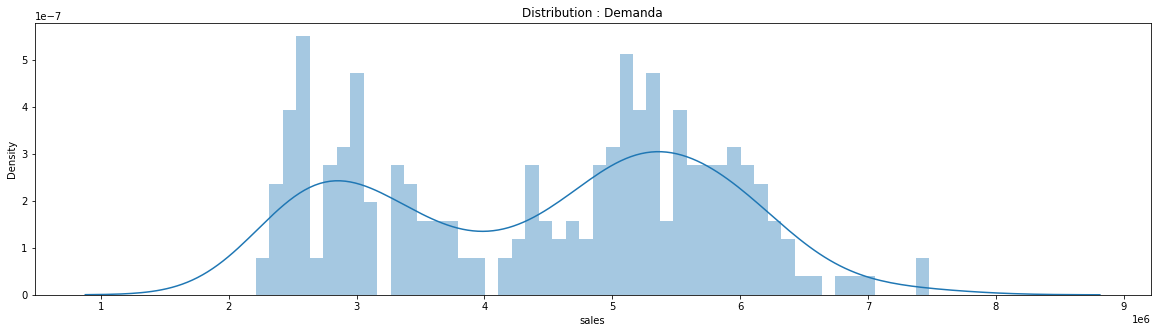

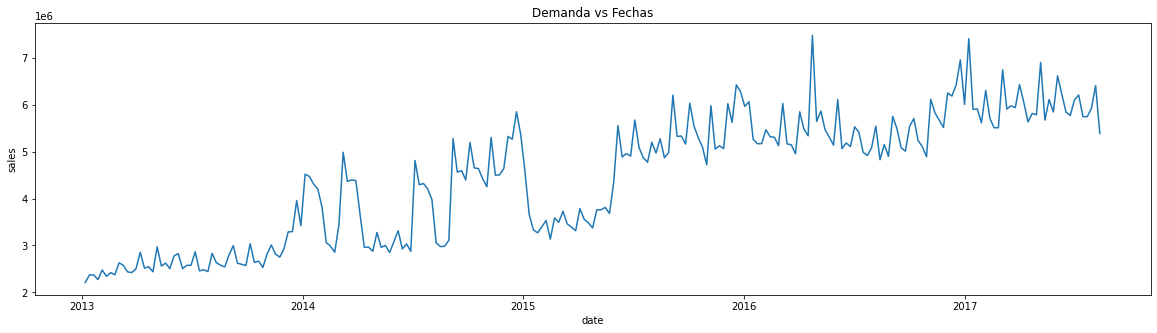

In [7]:
color1 = ['#296C92','#3EB489']
fig,ax = plt.subplots(nrows = 1, ncols = 1,figsize = (20,5))

sns.distplot(df1["sales"], bins=50);
plt.title('Distribution : Demanda')

fig,ax = plt.subplots(nrows = 1, ncols = 1,figsize = (20,5))
plt.subplot(1,1,1)
sns.lineplot(x = df1.index ,y = df1["sales"],data = df1,palette = color1);
plt.title('Demanda vs Fechas')

plt.show()
fig.tight_layout(pad = 2)



*   La suma de las ventas agregadas, si bien no es lo que finalmente se desea predecir (al final se desea obtener las ventas de cada familia por punto de venta), muestra la tendencia de las ventas en el tiempo. En el 2013 las ventas estaban por el orden de las dos millones de venta por SEMANA y en el 2017 por los seis millones, lo que muestra una tendencia positiva. 
*   Hay semanas en las que se presentan picos grandes de ventas con respecto a sus semanas colindantes, así que es interesante saber qué pasó en esas semanas específicas. Pudo haber días festivos, descuentos o puede deberse al precio del petróleo.
*   A principios del 2015 hubo una reducción significativa de las ventas, es importante averigüar a qué pudo deberse y saber si va a afectar el pronóstico futuro







#### Relación entre las ventas y el número de productos en descuento por semana

In [8]:
df2 = (df1 - df1.min()) / (df1.max() - df1.min())

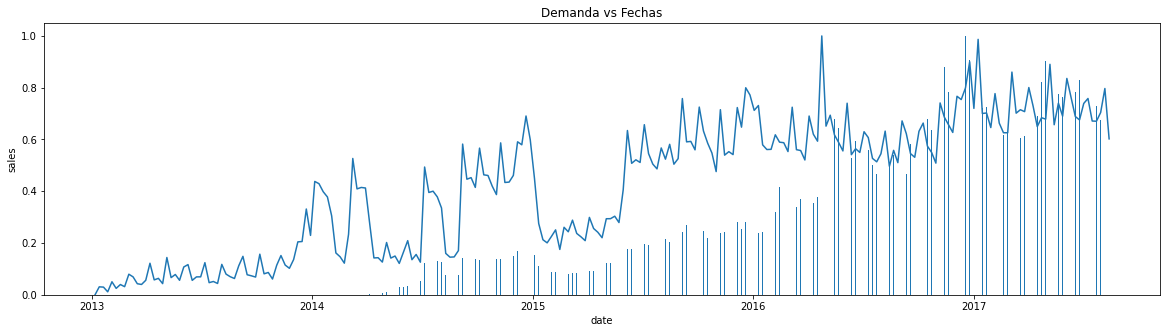

In [9]:
plt.figure(figsize = (20,5))
plt.bar(df2.index, df2["onpromotion"])
sns.lineplot(x = df2.index ,y = df2["sales"],data = df2,palette = color1);
plt.title('Demanda vs Fechas')

fig.tight_layout(pad = 2)
plt.show()



*   Con la gráfica anterior observamos que el número de productos en descuento en cada semana explican de forma bastante acertada el patrón de ventas. Cuando hay una disminución en los productos promocionados entre una semana y otra, generalmente observa un valle en las ventas. Asímismo,cuando hay un aumento en los productos promocionados se observa un pico en las ventas.

*   A partir del primer cuarto del 2016 se observa que aunque, se aumente la cantidad de productos en promoción, ya la demanda no aumenta en la misma proporción a años anteriores. Esto puede significar que la demanda de los productos llegó a un límite o que hay otra variable importante afectando la demanda a partir de ese trimestre.



### Relación entre las ventas y el precio del petróleo

In [10]:
#df_oil = df_oil.loc[df_oil["date"] <= "2017-08-15"]

df_oil_ = df_oil.copy(deep = True)
df_oil_['date'] = pd.to_datetime(df_oil_['date'])
df_oil_.set_index('date',inplace = True)
df_oil_ = df_oil_.resample('W').mean()
df_oil_

,dcoilwtico
date,
2013-01-06,93.076667
2013-01-13,93.380000
2013-01-20,94.582000
2013-01-27,95.412500
2013-02-03,97.332000
...,...
2017-08-06,49.520000
2017-08-13,49.076000
2017-08-20,47.524000


In [11]:
df_oil_norm = (df_oil_ - df_oil_.min()) / (df_oil_.max() - df_oil_.min())

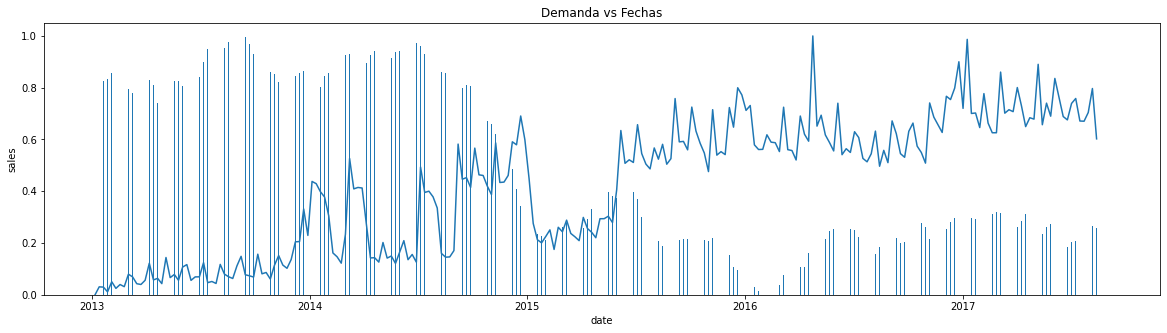

In [12]:
plt.figure(figsize = (20,5))
plt.bar(df_oil_norm.index, df_oil_norm["dcoilwtico"])
sns.lineplot(x = df2.index ,y = df2["sales"],data = df2,palette = color1);
plt.title('Demanda vs Fechas')

fig.tight_layout(pad = 2)
plt.show()



*   En este caso, vemos una relación inversamente proporcional entre el precio del combustible y la demanda de los productos que ofrece la companía.
*   Además de la cantidad de productos en promoción, el precio del petróleo en cada semana logra explicar bastante bien el patrón de demanda. Definitivamente, el precio del petróleo es algo que afecta las ventas de la empresa. En los últimos años el bajo precio del petróleo ha significado un aumento en las ventas de los productos ofrecidos.



#### Relación entre la demanda y el número de festivos en la semana

In [13]:
df_holidays_events = df_holidays_events.loc[(df_holidays_events["transferred"] == False)]

df_holidays_events_ = df_holidays_events.copy(deep = True)
df_holidays_events_['date'] = pd.to_datetime(df_holidays_events_['date'])
df_holidays_events_.set_index('date',inplace = True)
df_holidays_events_ = df_holidays_events_.resample('W').count()
df_holidays_events_

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-04,1,1,1,1,1
2012-03-11,0,0,0,0,0
2012-03-18,0,0,0,0,0
2012-03-25,0,0,0,0,0
2012-04-01,1,1,1,1,1
...,...,...,...,...,...
2017-12-03,0,0,0,0,0
2017-12-10,3,3,3,3,3
2017-12-17,0,0,0,0,0


In [14]:
df_holidays_events_norm = (df_holidays_events_ - df_holidays_events_.min()) / (df_holidays_events_.max() - df_holidays_events_.min())

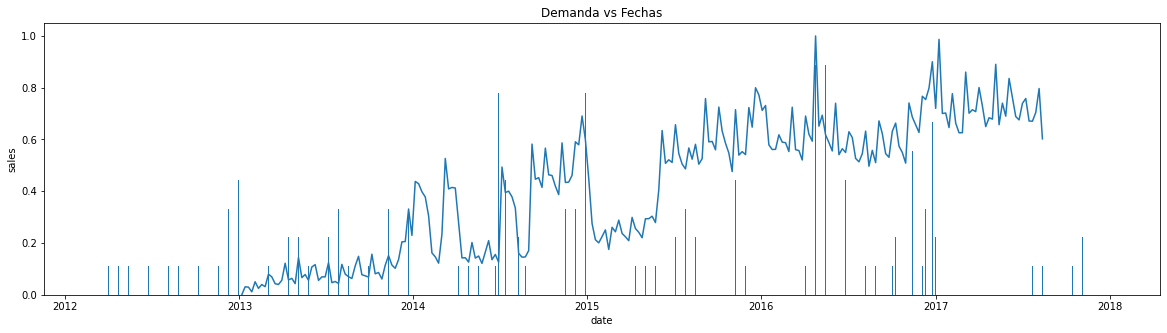

In [15]:
plt.figure(figsize = (20,5))
plt.bar(df_holidays_events_norm.index, df_holidays_events_norm["type"])
sns.lineplot(x = df2.index ,y = df2["sales"],data = df2,palette = color1);
plt.title('Demanda vs Fechas')

fig.tight_layout(pad = 2)
plt.show()



*   La cantidad de días festivos que ocurren en la semana no explican tan bien como las dos anteriores todo el pattrón de demanda, pero sí logran explicar algunos de los picos más importantes de ventas.
*   El día 16 de abril del 2016 ocurrió un terremoto en manabi, lo que ocasionó que muchas persoans donaran bienes de primera necesidad a los afectados. Claramente esto aumentó la cantidad de venta durante los días posteriores al suceso. Las autoridades de panamá declararon días festivos los siguientes 30 días hábiles después del terremoto.
*   Es normal que no todos los días festivos afecten de igual forma el patrón de demanda, pues no todos ellos son días comerciales. 
*   Por lo anterior, esta es una variable que debe tratarse con cuidado, pues tratar todos los días festivos por igual podría confundir el modelo cuando solo una parte de ellos explican ventas.


In [16]:
df_holidays_events.loc[(df_holidays_events["date"] >= "2016-04-16") & (df_holidays_events["date"] <= "2016-06-20")]

,date,type,locale,locale_name,description,transferred
219,2016-04-16,event,national,ecuador,terremoto manabi,False
220,2016-04-17,event,national,ecuador,terremoto manabi+1,False
221,2016-04-18,event,national,ecuador,terremoto manabi+2,False
222,2016-04-19,event,national,ecuador,terremoto manabi+3,False
223,2016-04-20,event,national,ecuador,terremoto manabi+4,False
224,2016-04-21,holiday,local,riobamba,cantonizacion de riobamba,False
225,2016-04-21,event,national,ecuador,terremoto manabi+5,False
226,2016-04-22,event,national,ecuador,terremoto manabi+6,False
227,2016-04-23,event,national,ecuador,terremoto manabi+7,False
228,2016-04-24,event,national,ecuador,terremoto manabi+8,False
